Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.9538 - val_loss: 0.7799
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6590 - val_loss: 0.4330
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3613 - val_loss: 0.1761
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1278 - val_loss: 0.0422
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0298 - val_loss: 0.0148
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0107
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0073
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_

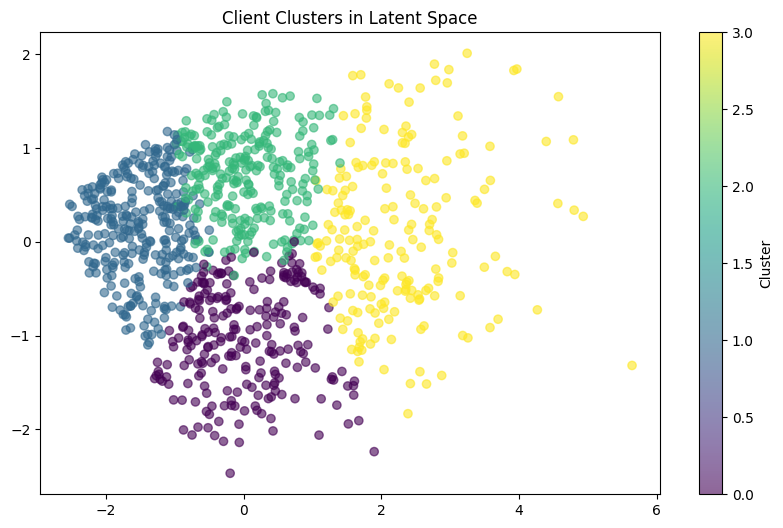

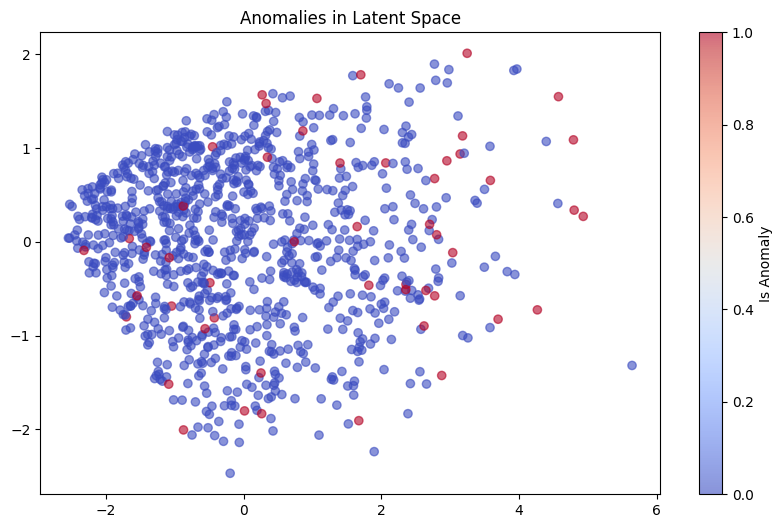

   client_id  trading_volume  engagement_score  email_open_rate  \
0          1      109.934283         63.993554         0.407106   
1          2       97.234714         59.246337         0.066010   
2          3      112.953771         50.596304         0.348821   
3          4      130.460597         43.530632         0.110998   
4          5       95.316933         56.982233         0.808235   

   website_visits  cluster  reconstruction_error  is_anomaly  
0               8        0              0.000631       False  
1              13        0              0.000124       False  
2              11        1              0.001546       False  
3               6        3              0.002262       False  
4               8        2              0.000075       False  
Anomalies Detected:
     client_id  trading_volume  engagement_score  email_open_rate  \
37          38       60.806598         35.356251         0.624784   
73          74      131.292873         37.170078         0.89

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

def generate_fake_data(num_clients=1000):
    np.random.seed(42)
    data = {
        "client_id": np.arange(1, num_clients + 1),
        "trading_volume": np.random.normal(100, 20, num_clients),
        "engagement_score": np.random.normal(50, 10, num_clients),
        "email_open_rate": np.random.uniform(0, 1, num_clients),
        "website_visits": np.random.poisson(10, num_clients),
    }
    return pd.DataFrame(data)

df = generate_fake_data(1000)

scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=["client_id"]))

input_dim = X.shape[1]
encoding_dim = 8

input_layer = Input(shape=(input_dim,))
encoder_layer1 = Dense(64, activation="relu")(input_layer)
encoder_layer2 = Dense(32, activation="relu")(encoder_layer1)
encoder_output = Dense(encoding_dim, activation="relu")(encoder_layer2)

decoder_layer1 = Dense(32, activation="relu")(encoder_output)
decoder_layer2 = Dense(64, activation="relu")(decoder_layer1)
decoder_output = Dense(input_dim, activation="linear")(decoder_layer2)

autoencoder = Model(inputs=input_layer, outputs=decoder_output)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(X, X, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

encoder = Model(inputs=input_layer, outputs=encoder_output)
latent_space = encoder.predict(X)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(latent_space)

df["cluster"] = clusters

reconstructed_data = autoencoder.predict(X)
reconstruction_error = np.mean(np.square(X - reconstructed_data), axis=1)
df["reconstruction_error"] = reconstruction_error

threshold = np.percentile(reconstruction_error, 95)
df["is_anomaly"] = df["reconstruction_error"] > threshold

pca = PCA(n_components=2)
latent_space_2d = pca.fit_transform(latent_space)

plt.figure(figsize=(10, 6))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=df["cluster"], cmap="viridis", alpha=0.6)
plt.title("Client Clusters in Latent Space")
plt.colorbar(label="Cluster")
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=df["is_anomaly"], cmap="coolwarm", alpha=0.6)
plt.title("Anomalies in Latent Space")
plt.colorbar(label="Is Anomaly")
plt.show()

print(df.head())
print("Anomalies Detected:")
print(df[df["is_anomaly"]])